# ECE 271A HW5

**Import Libraries**

In [1]:
import sys
import imageio
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.fftpack import dct
from numpy.linalg import inv,det
from scipy.stats import multivariate_normal

**Load Data**

In [2]:
train_samples = loadmat('./data/TrainingSamplesDCT_8_new.mat')
train_samples_fg = train_samples['TrainsampleDCT_FG']
train_samples_bg = train_samples['TrainsampleDCT_BG']

In [3]:
zig_zag = np.genfromtxt('./data/zig_zag_pattern.txt', dtype=np.int64).flatten()

In [4]:
image = loadmat('./data/cheetah.mat')['img']

In [5]:
ground_truth = np.array(imageio.imread('./data/cheetah_mask.bmp'), dtype=np.float64)/255

**Helper Functions**

In [6]:
def zz_scan(block):
    scanned = np.zeros(64)
    for i in range(64):
        scanned[zig_zag[i]] = block[i]
    return scanned

In [7]:
def dct2d(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho').flatten()

In [8]:
def process_image():
    transformed_blocks = []
    for i in range(image.shape[0]-8):
        for j in range(image.shape[1]-8):
            block = image[i:i+8,j:j+8]
            transformed_block = dct2d(block).flatten()
            transformed_block = zz_scan(transformed_block)
            transformed_blocks.append(transformed_block)
    return np.array(transformed_blocks)

In [9]:
def random_init(C, M, D, W=0.25):
    pi = np.ones(C)/C
    mu = np.random.randn(C, D)
    sigma = []
    for c in range(C):
        sigma.append(np.diag(np.random.normal(M, W, size=D)))
    sigma = np.array(sigma)
    return pi, mu, sigma

In [10]:
def mean_splitting(C, M, D):
    pi = np.ones(C)/C
    mu = []
    mu_0 = np.random.randn(1, D)
    sigma = []
    for c in range(C):
        mu.append((1+c*sys.float_info.epsilon)*mu_0)
        sigma.append(np.diag(np.random.normal(M, 0.3, size=D)))
    mu = np.array(mu)
    sigma = np.array(sigma)
    return pi, mu, sigma

In [11]:
def diff(A, B):
    return np.sum(np.absolute(A - B))

In [12]:
def EM(C, M, D, sample, max_iter):
    e = 1e-6
    pi,mu,cov = random_init(C, M, D)
    for i in range(max_iter):
        # E step
        H = []
        for c in range(C):
            H.append(multivariate_normal.pdf(sample, mean=mu[c,:], cov=cov[c,:,:]) * pi[c])
        H = np.array(H).T
        H /= np.sum(H,axis = 1)[:,np.newaxis]
        H = np.sum(H,axis = 0)
        
        # M step
        new_pi = H/sample.shape[0]
        new_mu = []
        new_cov = []
        for c in range(C):
            new_mu.append(np.sum(H[:, c][:, np.newaxis]*sample, axis=0)/H[c])
            temp = np.sum(((sample - mu[c, :]) ** 2) * H[:, c][:, np.newaxis], axis=0) / H[c]
            temp[temp < e] = e
            new_cov.append(np.diag(temp))
            
        # check convergence every 10 iterations
        if (i+1) % 10 == 0:
            if (diff(pi, new_pi) < e) and (diff(mu, np.array(new_mu)) < e) and (diff(cov, np.array(new_cov)) < e):
                break
        pi = new_pi
        mu = np.array(new_mu)
        cov = np.array(new_cov)
    return pi, mu, cov

In [13]:
def bdr(fg, fg_pi, fg_mu, fg_cov, bg, bg_pi, bg_mu, bg_cov, dim):
    l = image.shape[0]-8
    w = image.shape[1]-8
    d = fg_mu.shape[0]
    fg_mu= fg_mu[:,:dim]
    fg_cov= fg_cov[:,:dim,:dim]
    bg_mu= bg_mu[:,:dim]
    bg_cov= bg_cov[:,:dim,:dim]
    blocks = process_image()[:, :dim]
    p_cheetah = np.zeros(l*w)
    p_grass = np.zeros(l*w)
    A = np.zeros(l*w)
    for i in range(d):
        p_cheetah += multivariate_normal.pdf(blocks, mean=fg_mu[i], cov=fg_cov[i]) * fg_pi[i]
        p_grass += multivariate_normal.pdf(blocks, mean=bg_mu[i], cov=bg_cov[i]) * bg_pi[i]
    A = p_cheetah - p_grass
    A = np.where(A>0, 1, 0)
    A = np.reshape(A,(l,w))                
    A = np.lib.pad(A,(4,4),'constant',constant_values = 0)
    return A

In [14]:
def remove_empty():
    pass

In [15]:
def mvg(x, mu, cov):
    part1 = 1 / ( ((2* np.pi)**(len(mu)/2)) * (np.linalg.det(cov)**(1/2)) )
    part2 = (-1/2) * ((x-mu).T.dot(np.linalg.inv(cov))).dot((x-mu))
    return float(part1 * np.exp(part2))

**Some Settings**

In [16]:
C = 8
M = 5
D = train_samples_fg.shape[1]
iterations = 250
dimension = np.array((1,2,4,8,16,24,32,40,48,56,64))

$P_{X|Y}(x|i)=\sum_{c=1}^{C}\pi_{c}G(x,\mu_{c},\Sigma_{c})$

# a)

In [17]:
error_list_a = []
for m_fg in range(M):
    fg_pi, fg_mu, fg_cov = EM(C, M, D, train_samples_fg, iterations)
    for m_bg in range(M):
        bg_pi, bg_mu, bg_cov = EM(C, M, D, train_samples_bg, iterations)
        error_list = []
        for dim in dimension:
            A = bdr(train_samples_fg, fg_pi, fg_mu, fg_cov, train_samples_bg, bg_pi, bg_mu, bg_cov, dim)
            error = A != ground_truth
            p_error = np.sum(error) / A.size
            error_list.append(p_error)
#             print('FG{} BG{} dim{} P(error) = {}'.format(m_fg, m_bg, dim, p_error))
        error_list_a.append(error_list)

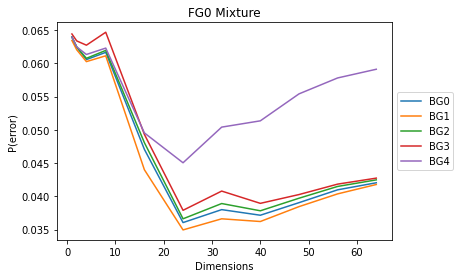

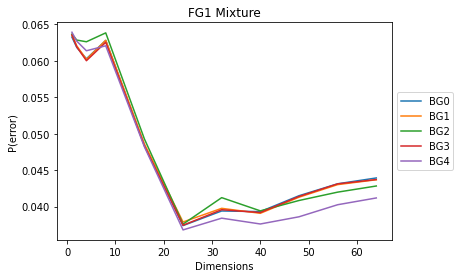

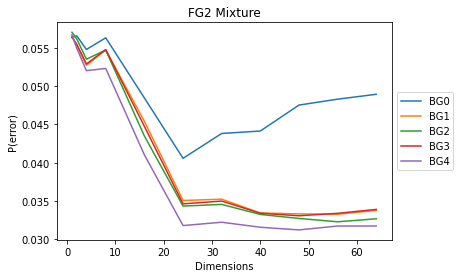

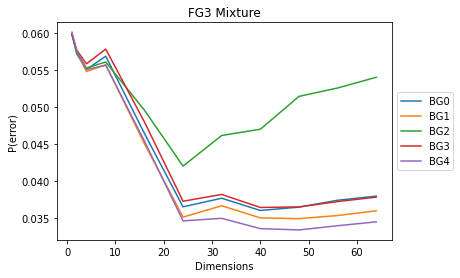

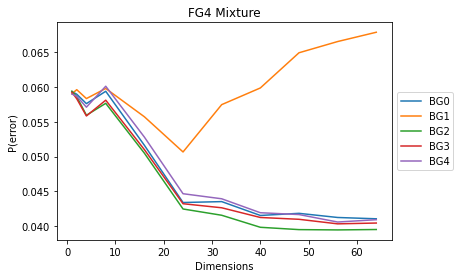

In [29]:
for i in range(M):
    for j in range(M):
        plt.plot(dimension, error_list_a[j+5*i], label='BG{}'.format(j))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('FG{} Mixture'.format(i))
    plt.xlabel('Dimensions')
    plt.ylabel('P(error)')
    plt.show()

The graphs above contain information on the probability of error with respect to different number of dimensions. Each foreground and background mixture models are paired together for comparison. We can see that the trend of each foreground and background pair is pretty similar. The error tends to decrease as the dimension increases, although it also seems that using 24 dimensions gives the best result for each curve. Each line is different from each other because of the initialization method. We used random initialization for the EM training of each foreground and background mixture combination, which clearly shows that certain initializations yield better results (e.g. FG0BG1 dim24, FG1BG4 dim24, FG2BG4 dim48, FG3BG4 dim48, FG4BG2 dim64). These results also fluctuate each time the program is ran due to the nature of random initialization. I have also tried to examined the impact of mean splitting compared to random initialization and found that the results are typically very similar because the EM algorithm converges eventually.

# b)

In [19]:
C = np.array((1, 2, 4, 8, 16, 32))
error_list_b = []
for c in C:
    fg_pi, fg_mu, fg_cov = EM(c, M, D, train_samples_fg, iterations)
    bg_pi, bg_mu, bg_cov = EM(c, M, D, train_samples_bg, iterations)
    error_list = []
    for dim in dimension:
        A = bdr(train_samples_fg, fg_pi, fg_mu, fg_cov, train_samples_bg, bg_pi, bg_mu, bg_cov, dim)
        error = A != ground_truth
        p_error = np.sum(error) / A.size
        error_list.append(p_error)
    error_list_b.append(error_list)

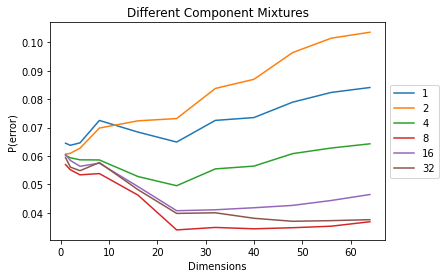

In [28]:
for i, c in enumerate(C):
    plt.plot(dimension, error_list_b[i],label = '{}'.format(c))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Different Component Mixtures')
plt.xlabel('Dimensions')
plt.ylabel('P(error)')
plt.show()

It seems that in general, higher number of mixtures generate better result. It's interesting to see that with lower number of mixtures, the probability of error increases as the dimension increases. On the other hand, with higher number of mixtures, the probability of error decreases as the dimension increases. This is likely due to the fact that lower number of mixtures does not capture the distribution of the cheetah images well, implying that the image is in fact composed of multiple different mixtures. From the observation that with a higher number of mixtures we have a generally lower probability of error, we can conclude that the distribution can always be captured with infinitely many Gaussian mixtures at the cost of compute time. In our result, the mixtures with 8 components performed the best, but it is not a guarantee that it can perform better relative to an even higher number of components than we have experiemented upon.